Description :-
The dataset represents **Mandal-wise horticultural crop statistics for the year 2022–23**. It provides a structured view of cultivation, production, and productivity across multiple horticultural categories, helping us understand agricultural trends at a local administrative level.

### 1. Structure and Size

* The dataset contains **rows representing Mandals and crop types**, with attributes describing cultivation area, production, and yield.
* Each row corresponds to a unique **(Mandal, Crop)** pair.
* The dataset is clean, well-structured, and suitable for statistical and predictive analysis.

### 2. Columns / Attributes

The dataset typically includes the following fields:

**District / Mandal Name** → The administrative unit where cultivation is recorded.
**Crop Name** → Specific horticultural crop (fruits, vegetables, spices, plantation crops, flowers).
**Area (Hectares)** → Land under cultivation for the crop.
**Production (Metric Tons)** → Quantity of output harvested.

These three agricultural indicators (Area, Production, Yield) are essential for understanding both **scale of cultivation** and **efficiency of farming practices**.

### 3. Crop Coverage

* The dataset covers a wide range of horticultural crops, including:

  * **Fruits** (e.g., Mango, Banana, Citrus, Papaya, Guava)
  * **Vegetables** (e.g., Tomato, Brinjal, Okra, Cabbage, Onion, Potato)
  * **Spices & Condiments** (e.g., Chillies, Turmeric, Coriander, Ginger, Garlic)
  * **Plantation Crops** (e.g., Coconut, Cashew, Arecanut)
  * **Flowers & Ornamentals** (Marigold, Jasmine, Rose, etc.)

This wide variety makes it useful for **comparative analysis across crop categories**.

### 4. Granularity

* Data is provided at the **Mandal level**, which is a fine-grained administrative division below districts.
* This enables **micro-level agricultural planning**, highlighting productivity gaps and regional differences in crop preferences.

### 5. Usefulness of the Dataset

**Agricultural Policy** → Helps governments identify high-performing regions and allocate resources accordingly.
**Market Forecasting** → Provides insights into expected supply of crops, useful for pricing and logistics.
**Comparative Studies** → Enables comparisons across Mandals, crop categories, and productivity levels.



In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, lower, upper, sum as _sum, avg
from pyspark.sql.types import DoubleType

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
spark = SparkSession.builder.appName("CropAnalytics_Visualizations").getOrCreate()

INPUT_CSV = "horticulture-Mandal_wise_Crop_Area_Production_and_Yield_data _2022-23.csv"

# Load Data

df = spark.read.csv(INPUT_CSV, header=True, inferSchema=True)


# Clean strings
for c, t in df.dtypes:
    if t == 'string':
        df = df.withColumn(c, trim(col(c)))

# Normalize
df = df.withColumn("area_production_norm", lower(col("area_production")))
df = df.withColumn("crop_name_norm", upper(col("crop_name")))
df = df.withColumn("value_numeric", col("value").cast(DoubleType()))

In [36]:
# Total Area per Crop
crop_area = df.filter(col("area_production_norm") == "area") \
    .groupBy("crop_name_norm") \
    .agg(_sum("value_numeric").alias("total_area")) \
    .orderBy(col("total_area").desc())


print("Top crops by area:")
crop_area.show(10, False)

Top crops by area:
+-----------------------------------------------------------------------+------------------+
|crop_name_norm                                                         |total_area        |
+-----------------------------------------------------------------------+------------------+
|TOTAL POLYHOUSE FLOWERS                                                |870037.0000000003 |
|TOTAL SPICES                                                           |321572.8699999999 |
|MUSKMELON                                                              |318001.31000000006|
|MANGO                                                                  |266461.08999999997|
|RED CHILLIES                                                           |259791.83999999985|
|TOTAL OPEN CULTIVATED VEGTABLES                                        |155609.25         |
|GRAND TOTAL OF HORTICULTURE,AGRO FORESTRY,BORDER PLANTATION,SERICULTURE|146070.99000000002|
|TOTAL POLYHOUSE VEGETABLES                        

In [37]:
# Total Production per Crop (match anything containing 'production')
crop_prod = df.filter(col("area_production_norm").contains("production")) \
    .groupBy("crop_name_norm") \
    .agg(_sum("value_numeric").alias("total_prod")) \
    .orderBy(col("total_prod").desc())

print("Top crops by production:")
crop_prod.show(10, False)

Top crops by production:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|crop_name_norm                                                                                                                                                                                                   |total_prod        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|TOTAL POLYHOUSE FLOWERS                                                                                                                                                                                          |4514815.990000002 |
|MUSKMELON                                         

In [38]:
# Convert to Pandas for plotting
crop_area_pd = crop_area.limit(15).toPandas()
crop_prod_pd = crop_prod.limit(15).toPandas()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4988\1708213158.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_area_pd, x="total_area", y="crop_name_norm", palette="viridis")


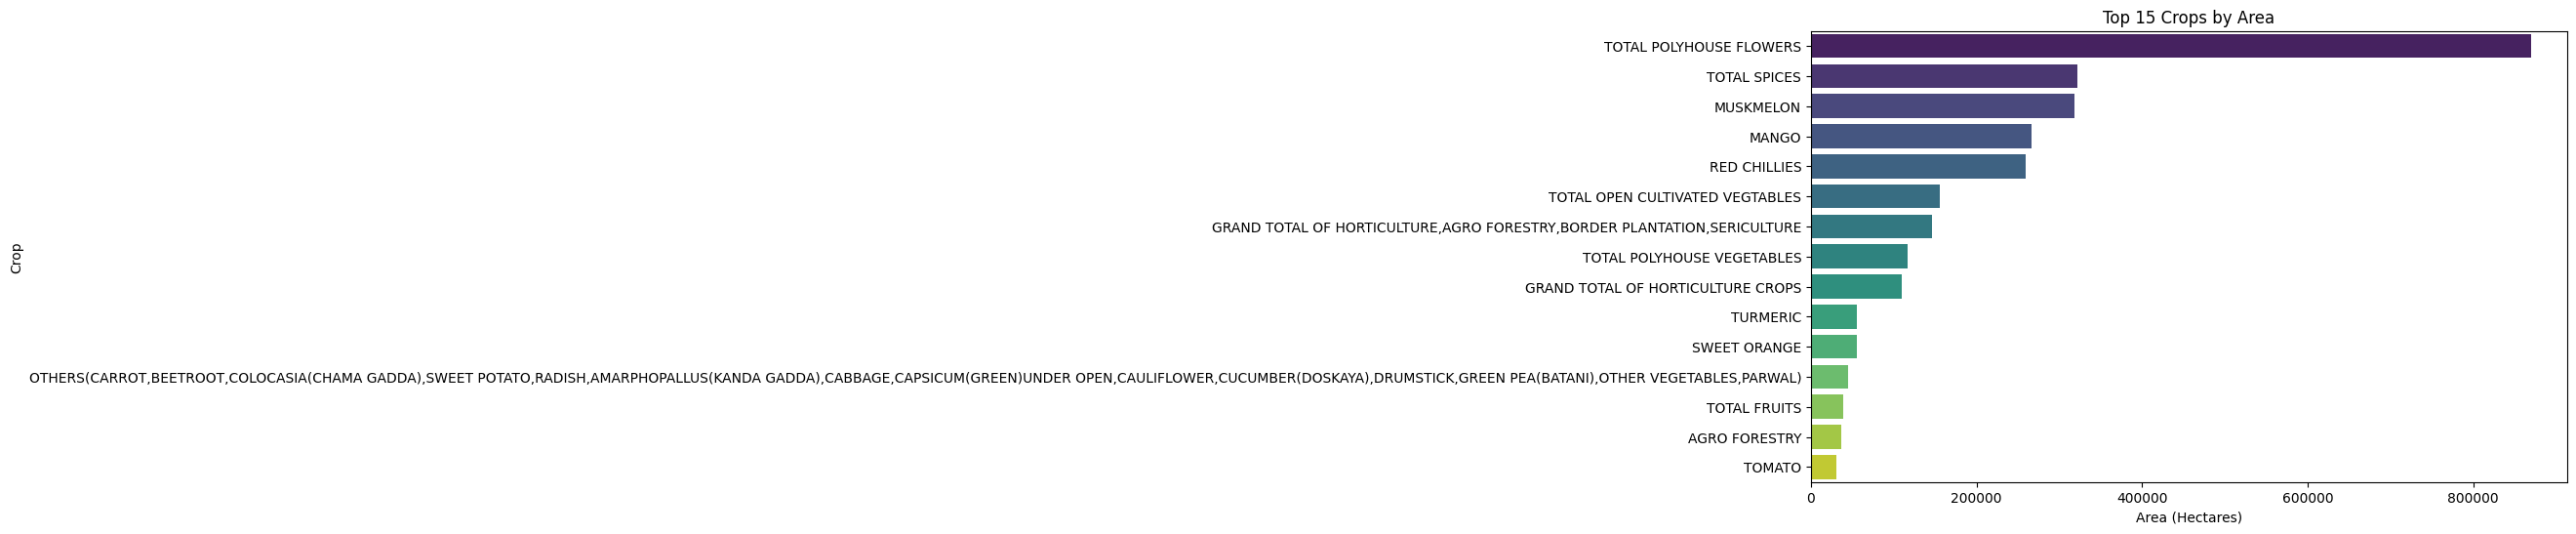

In [39]:
# Visualizations
# -----------------------------

plt.figure(figsize=(10,6))
sns.barplot(data=crop_area_pd, x="total_area", y="crop_name_norm", palette="viridis")
plt.title("Top 15 Crops by Area")
plt.xlabel("Area (Hectares)")
plt.ylabel("Crop")
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4988\1904038639.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crop_prod_pd, x="total_prod", y="crop_name_norm", palette="plasma")


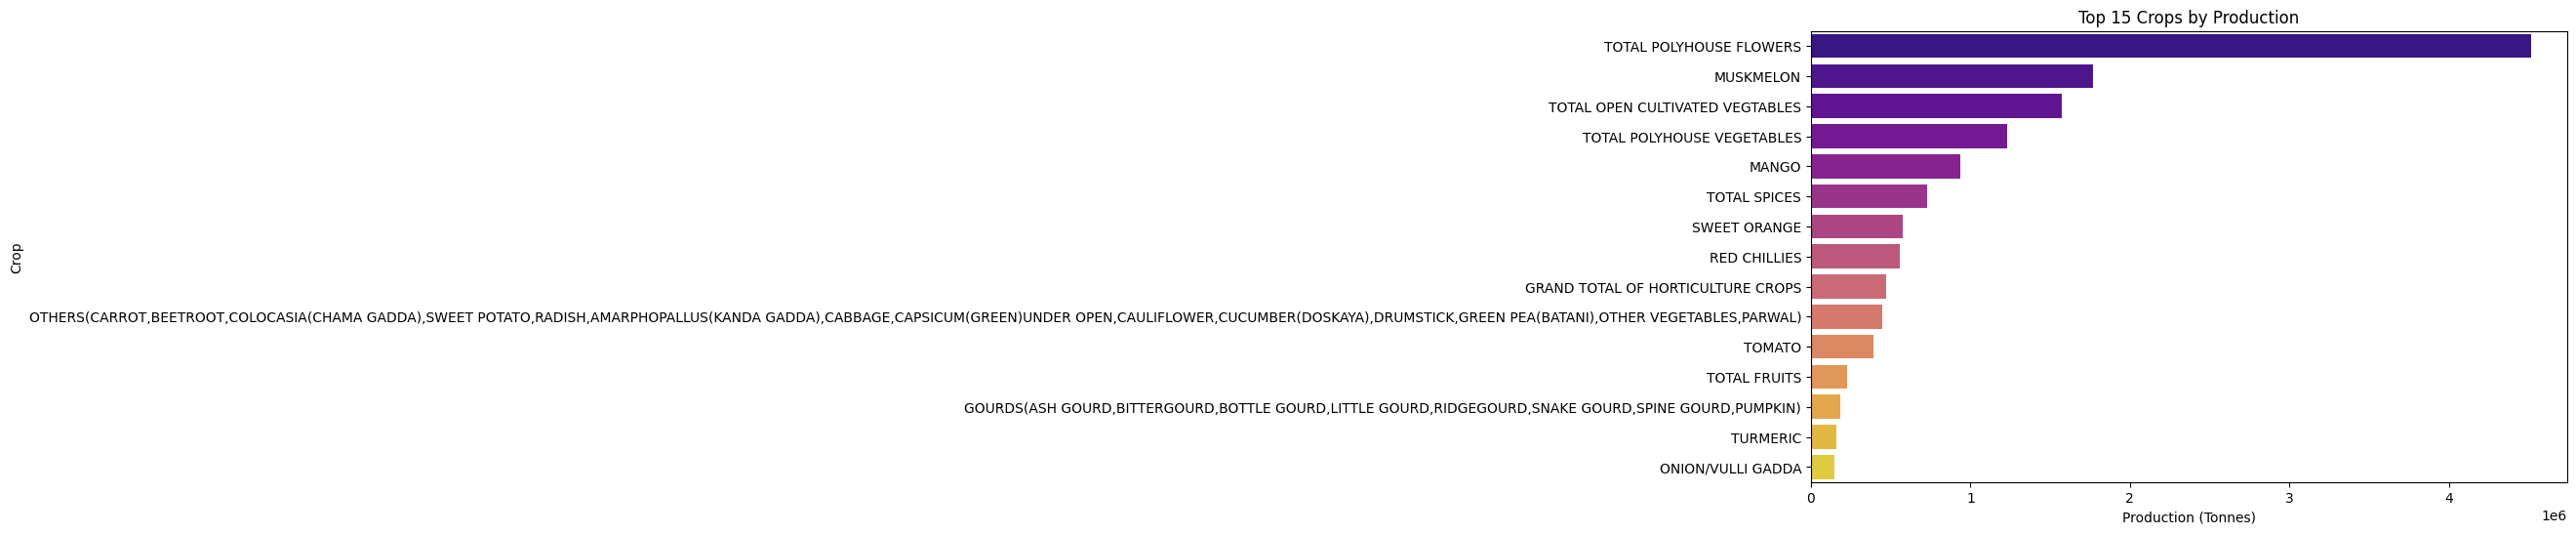

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(data=crop_prod_pd, x="total_prod", y="crop_name_norm", palette="plasma")
plt.title("Top 15 Crops by Production")
plt.xlabel("Production (Tonnes)")
plt.ylabel("Crop")
plt.show()


                  total_area  total_production
total_area          1.000000          0.818101
total_production    0.818101          1.000000


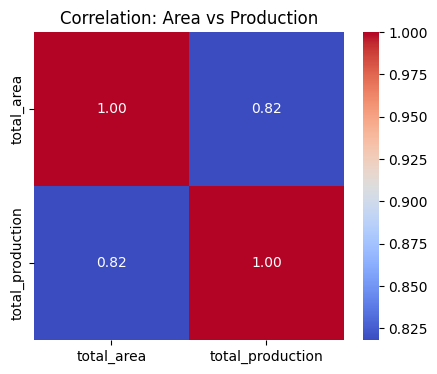

In [41]:
from pyspark.sql.functions import sum as _sum, col

# Step 1: Aggregate AREA per Mandal
area_df = df.filter(col("area_production") == "Area") \
    .groupBy("mandal") \
    .agg(_sum("value").alias("total_area"))

# Step 2: Aggregate PRODUCTION per Mandal
prod_df = df.filter(col("area_production").contains("Production")) \
    .groupBy("mandal") \
    .agg(_sum("value").alias("total_production"))

# Step 3: Join
mandal_agg = area_df.join(prod_df, on="mandal", how="inner")

# Step 4: Convert to Pandas
mandal_pd = mandal_agg.toPandas()

# Step 5: Correlation Matrix
corr_matrix = mandal_pd.corr(numeric_only=True)
print(corr_matrix)

# Step 6: Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Area vs Production")
plt.show()


Project Summary:-

The analysis of the horticulture dataset (2022–23) reveals important insights into agricultural production patterns:
**Crop Coverage** → Some crops dominate in terms of area (hectares), while others show higher productivity despite smaller cultivation regions.
**Production Trends** 
* Major fruits and vegetables contribute significantly to overall output.
* Commercial crops and flowers, though occupying less area, yield high value.
**Yield Variations** → Productivity differs across Mandals, reflecting differences in soil fertility, irrigation facilities, and farming practices.
**Regional Diversity** → Each Mandal shows variation in crop preference and yield, indicating localized agricultural practices.

The dataset highlights the **diverse horticultural landscape across Mandals**. While some Mandals excel in large-scale cultivation, others achieve higher efficiency with better yields. This information can support **policy-making, resource allocation, and crop planning strategies** for improving productivity and ensuring sustainable horticulture development in the region.